<a href="https://colab.research.google.com/github/rabnawaz172/Voice_pathology_2/blob/main/Voice_deep_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.utils import shuffle

# Assuming the Google Drive dataset folder is loaded to a local directory using Google Colab
# Mount Google Drive first to access the files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing 111 files in class 'Normal' from /content/drive/MyDrive/Voice_2/Train
Processing 117 files in class 'Pathol' from /content/drive/MyDrive/Voice_2/Train
Processing 47 files in class 'Normal' from /content/drive/MyDrive/Voice_2/Test_4
Processing 49 files in class 'Pathol' from /content/drive/MyDrive/Voice_2/Test_4
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.3946 - loss: 10.3948 - val_accuracy: 0.6957 - val_loss: 0.6253
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5687 - loss: 1.3591 - val_accuracy: 0.5870 - val_loss: 0.6712
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6650 - loss: 0.6264 - val_accuracy: 0.4348 - val_loss: 0.7160
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6697 - loss: 0.6329 - val_accuracy: 0.7174 - val_loss: 0.5795
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6344 - loss: 0.6163 - val_accuracy: 0.6957 - val_loss: 0.5980
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.6922 - loss: 0.5765 - val_accuracy: 0.7391 - val_loss: 0.5726
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7341 - loss: 0.5359 - val_accuracy: 0.6739 - val_loss: 0.5805
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7301 - loss: 0.5269 - val_accuracy: 0.7609 - val_loss: 0.529

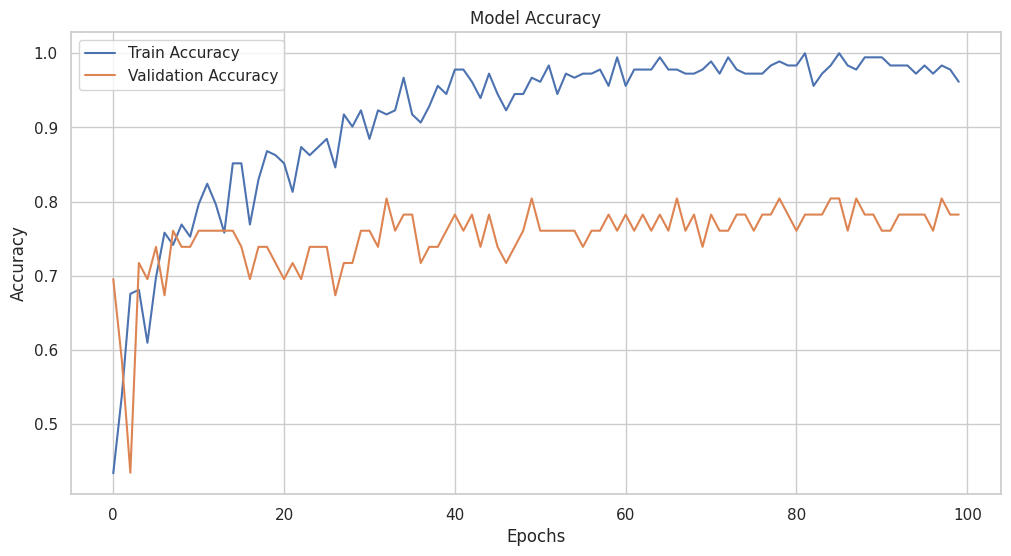

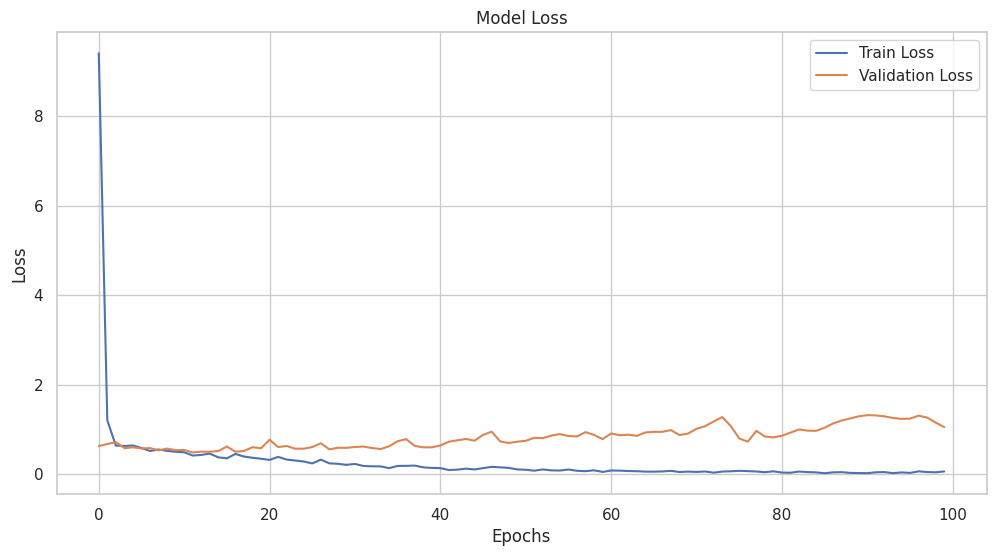

In [110]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style with grid
sns.set(style="whitegrid")

# Base paths
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_4'  # Separate test data

# Audio class labels
classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Fixed audio length and Mel-spectrogram parameters
MAX_AUDIO_LENGTH = 16000  # 1 second at 16kHz
N_MELS = 64
TIME_STEPS = 32  # Desired time steps for model input

# Function to extract and process Mel-spectrogram
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH, time_steps=TIME_STEPS):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # Pad or truncate audio to MAX_AUDIO_LENGTH
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)), mode='constant')
        else:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Ensure time_steps = 32 by padding or truncating
        t = mel_spec_db.shape[1]
        if t < time_steps:
            pad_width = time_steps - t
            mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif t > time_steps:
            mel_spec_db = mel_spec_db[:, :time_steps]

        # Expand to 3 channels (RGB-like)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

        return mel_spec_db_rgb

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((N_MELS, time_steps, 3))  # Return zero vector in case of error

# Function to load all data from a base path
def load_data(base_path, classes, labels):
    features = []
    targets = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}' from {base_path}")
        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
    return np.array(features), np.array(targets)

# Load training data (used for train + validation)
X_train_val, y_train_val = load_data(train_path, classes, labels)

# Load test data (unseen, used only for final evaluation)
X_test, y_test = load_data(test_path, classes, labels)

# Split training data into train and validation (80% train, 20% val)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Build the CNN model
model_hyb = models.Sequential([
    layers.InputLayer(input_shape=(N_MELS, TIME_STEPS, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_hyb.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_hyb = model_hyb.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate on validation data
Y_val_pred = (model_hyb.predict(X_val) > 0.5).astype(int)

val_accuracy = accuracy_score(Y_val, Y_val_pred)
val_precision = precision_score(Y_val, Y_val_pred)
val_recall = recall_score(Y_val, Y_val_pred)
val_f1 = f1_score(Y_val, Y_val_pred)

print(f"Validation Metrics - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Evaluate on test data
Y_test_pred = (model_hyb.predict(X_test) > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, Y_test_pred)
test_precision = precision_score(y_test, Y_test_pred)
test_recall = recall_score(y_test, Y_test_pred)
test_f1 = f1_score(y_test, Y_test_pred)

print(f"Test Metrics - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history_hyb.history['accuracy'], label='Train Accuracy')
plt.plot(history_hyb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_hyb.history['loss'], label='Train Loss')
plt.plot(history_hyb.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Processing 111 files in class 'Normal'
Processing 117 files in class 'Pathol'
Processing 47 files in class 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in class 'Pathol'
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 983ms/step - accuracy: 0.4420 - loss: 3.5252 - val_accuracy: 0.5104 - val_loss: 1.2904
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 973ms/step - accuracy: 0.5761 - loss: 1.5864 - val_accuracy: 0.5625 - val_loss: 0.7385
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 877ms/step - accuracy: 0.5613 - loss: 1.2762 - val_accuracy: 0.6771 - val_loss: 0.5417
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 772ms/step - accuracy: 0.5990 - loss: 0.8895 - val_accuracy: 0.6354 - val_loss: 0.5828
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 958ms/step - accuracy: 0.6272 - loss: 0.8612 - val_accuracy: 0.6875 - val_loss: 0.5182
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7017 - loss: 0.7025 - val_accuracy: 0.6875 - val_loss: 0.4868
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 891ms/step - accuracy: 0.6873 - loss: 0.6937 - val_accuracy: 0.7812 - val_loss: 0.4441
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 881ms/step - accuracy: 0.7044 

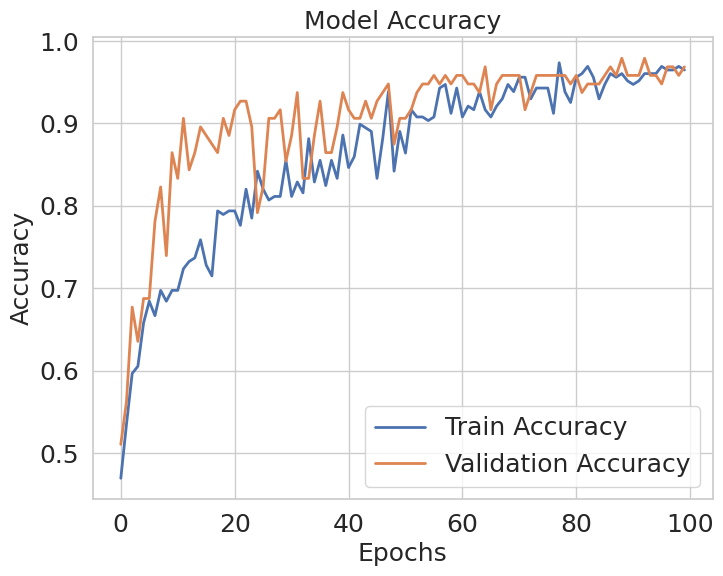

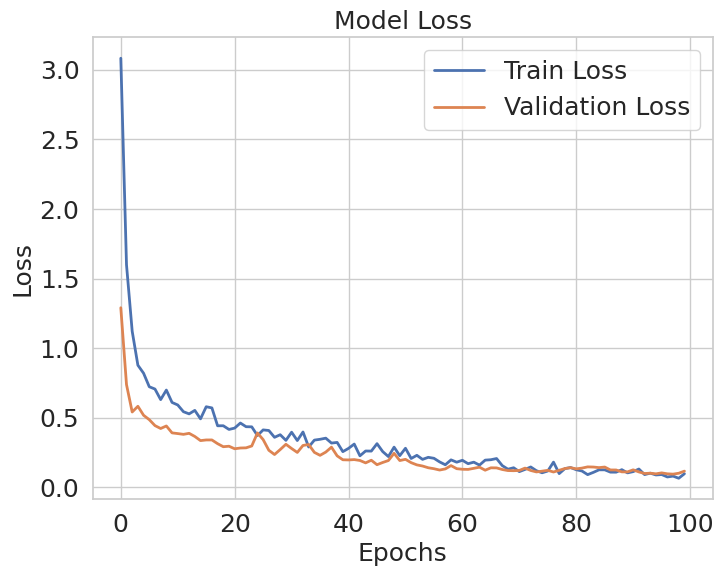

In [111]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Set seaborn style with grid
sns.set(style="whitegrid")

# Set base paths for training and validation
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_4'  # Separate test data


classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define the maximum audio length and padding
MAX_AUDIO_LENGTH = 16000  # 1 second of audio at 16 kHz sampling rate

# Function to extract Mel-spectrogram from the audio
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        # Load audio file with librosa (no resampling)
        y, sr = librosa.load(file_path, sr=None)
        # If the audio is shorter than max_len, pad it with zeros
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        # If the audio is longer than max_len, truncate it
        elif len(y) > max_len:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Reshape to match the input of the model (height, width, channels)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Shape (64, time, 1)

        # Replicate the single channel to simulate RGB channels (64, time, 3)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Return a zero vector in case of error
    return mel_spec_db_rgb

def load_data(base_path, classes, labels):
    features = []
    target = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            target.append(labels[class_name])
    return np.array(features), np.array(target)

# Load training and validation data
X_train, Y_train = load_data(train_path, classes, labels)
X_val, Y_val = load_data(test_path, classes, labels)

# Build the VGGish model for transfer learning
# Load VGG16 as base model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model_trans = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_trans.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_trans = model_trans.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,  # Adjust epochs as needed
    batch_size=32,  # Adjust batch size as needed
    verbose=1
)

# Evaluate the model
Y_val_pred_trans = (model_trans.predict(X_val) > 0.5).astype(int)

accuracy = accuracy_score(Y_val, Y_val_pred_trans)
precision = precision_score(Y_val, Y_val_pred_trans)
recall = recall_score(Y_val, Y_val_pred_trans)
f1 = f1_score(Y_val, Y_val_pred_trans)

print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

plt.figure(figsize=(8, 6))
plt.plot(history_trans.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_trans.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Plot training loss history
plt.figure(figsize=(8, 6))
plt.plot(history_trans.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_trans.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

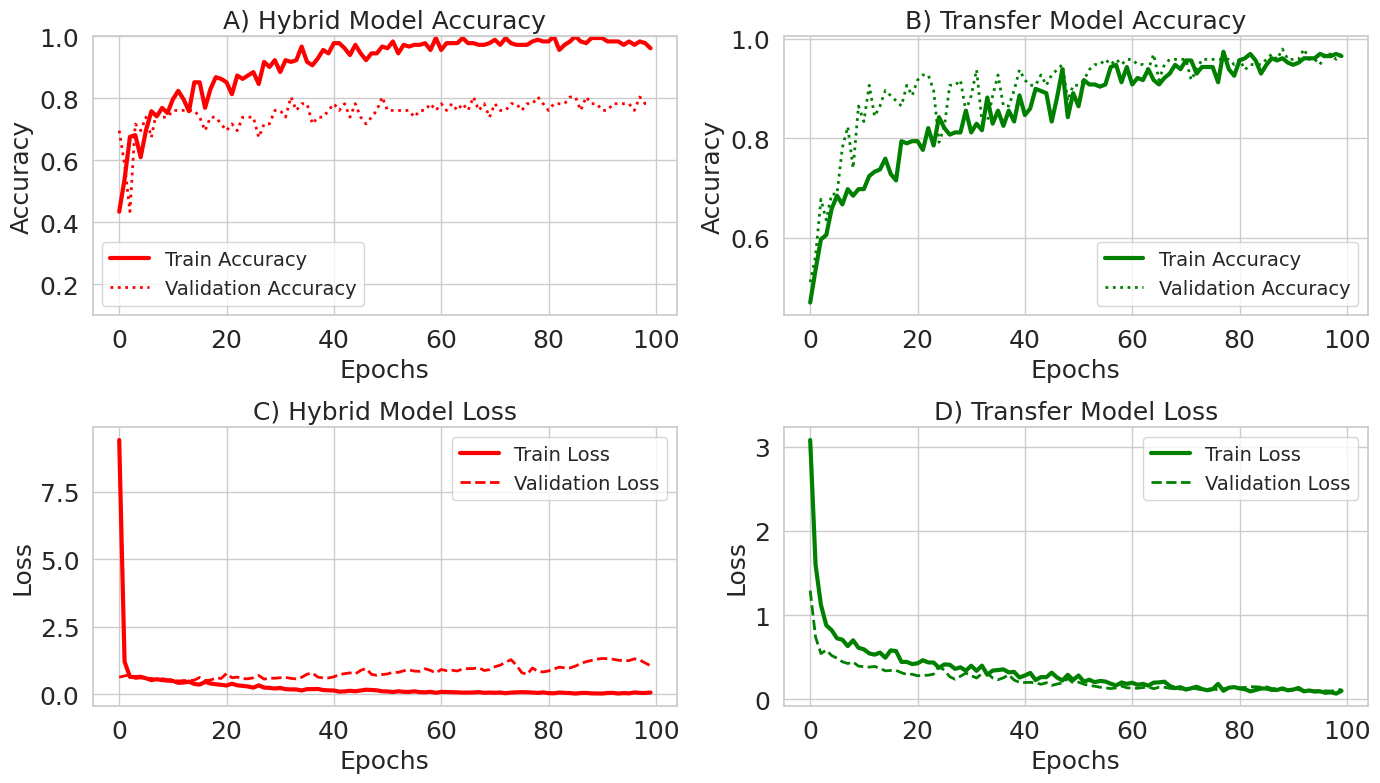

In [112]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ----------------------------
# Subplot A: Hybrid Model - Accuracy
# ----------------------------
axes[0, 0].plot(history_hyb.history['accuracy'], label='Train Accuracy', linewidth=3, color='red')
axes[0, 0].plot(history_hyb.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='dotted', color='red')
axes[0, 0].set_title('A) Hybrid Model Accuracy', fontsize=18)
axes[0, 0].set_xlabel('Epochs', fontsize=18)
axes[0, 0].set_ylabel('Accuracy', fontsize=18)
axes[0, 0].set_ylim(0.1, 1.0)  # Focus on 90% to 100% range
axes[0, 0].tick_params(axis='both', which='major', labelsize=18)
axes[0, 0].legend(fontsize=14)
axes[0, 0].grid(True)

# ----------------------------
# Subplot B: Transfer Model - Accuracy
# ----------------------------
axes[0, 1].plot(history_trans.history['accuracy'], label='Train Accuracy', linewidth=3, color='green')
axes[0, 1].plot(history_trans.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='dotted', color='green')
axes[0, 1].set_title('B) Transfer Model Accuracy', fontsize=18)
axes[0, 1].set_xlabel('Epochs', fontsize=18)
axes[0, 1].set_ylabel('Accuracy', fontsize=18)
axes[0, 0].set_ylim(0.1, 1.0)
axes[0, 1].tick_params(axis='both', which='major', labelsize=18)
axes[0, 1].legend(fontsize=14)
axes[0, 1].grid(True)

# ----------------------------
# Subplot C: Hybrid Model - Loss
# ----------------------------
axes[1, 0].plot(history_hyb.history['loss'], label='Train Loss', linewidth=3, color='red')
axes[1, 0].plot(history_hyb.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='dashed', color='red')
axes[1, 0].set_title('C) Hybrid Model Loss', fontsize=18)
axes[1, 0].set_xlabel('Epochs', fontsize=18)
axes[1, 0].set_ylabel('Loss', fontsize=18)


axes[1, 0].tick_params(axis='both', which='major', labelsize=18)
axes[1, 0].legend(fontsize=14)
axes[1, 0].grid(True)

# ----------------------------
# Subplot D: Transfer Model - Loss
# ----------------------------
axes[1, 1].plot(history_trans.history['loss'], label='Train Loss', linewidth=3, color='green')
axes[1, 1].plot(history_trans.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='dashed', color='green')
axes[1, 1].set_title('D) Transfer Model Loss', fontsize=18)
axes[1, 1].set_xlabel('Epochs', fontsize=18)
axes[1, 1].set_ylabel('Loss', fontsize=18)

axes[1, 1].tick_params(axis='both', which='major', labelsize=18)
axes[1, 1].legend(fontsize=14)
axes[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

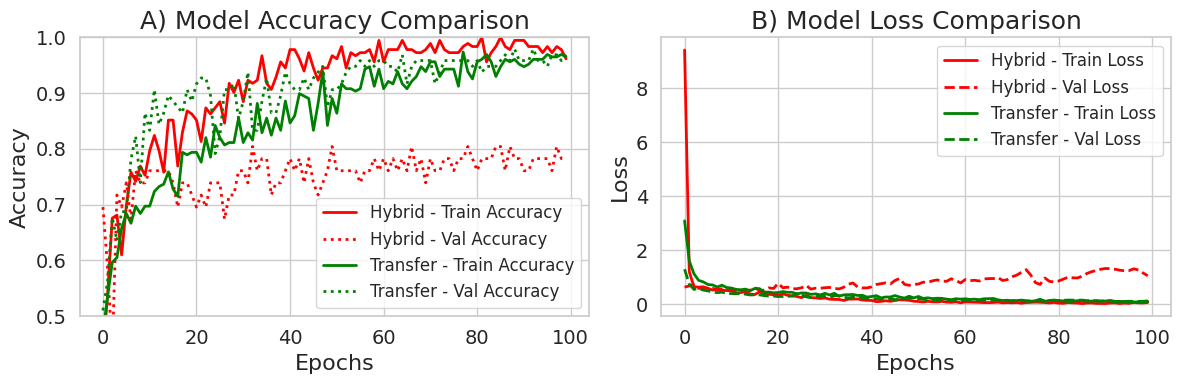

In [113]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Wider figure for side-by-side layout

# ----------------------------
# Subplot 0: Accuracy Comparison (Left)
# ----------------------------
# Hybrid model accuracy
axes[0].plot(history_hyb.history['accuracy'], label='Hybrid - Train Accuracy', linewidth=2, color='red')
axes[0].plot(history_hyb.history['val_accuracy'], label='Hybrid - Val Accuracy', linewidth=2, linestyle='dotted', color='red')

# Transfer learning model accuracy
axes[0].plot(history_trans.history['accuracy'], label='Transfer - Train Accuracy', linewidth=2, color='green')
axes[0].plot(history_trans.history['val_accuracy'], label='Transfer - Val Accuracy', linewidth=2, linestyle='dotted', color='green')

axes[0].set_title('A) Model Accuracy Comparison', fontsize=18)  # Added "A)"
axes[0].set_xlabel('Epochs', fontsize=16)
axes[0].set_ylabel('Accuracy', fontsize=16)
axes[0].set_ylim(0.5, 1.0)  # Focus on relevant range
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True)

# ----------------------------
# Subplot 1: Loss Comparison (Right)
# ----------------------------
# Hybrid model loss
axes[1].plot(history_hyb.history['loss'], label='Hybrid - Train Loss', linewidth=2, color='red')
axes[1].plot(history_hyb.history['val_loss'], label='Hybrid - Val Loss', linewidth=2, linestyle='dashed', color='red')

# Transfer learning model loss
axes[1].plot(history_trans.history['loss'], label='Transfer - Train Loss', linewidth=2, color='green')
axes[1].plot(history_trans.history['val_loss'], label='Transfer - Val Loss', linewidth=2, linestyle='dashed', color='green')

axes[1].set_title('B) Model Loss Comparison', fontsize=18)  # Added "B)"
axes[1].set_xlabel('Epochs', fontsize=16)
axes[1].set_ylabel('Loss', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

In [114]:
model_hyb.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,631,429 (6.22 MB)

 Trainable params: 543,809 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,087,620 (4.15 MB)

In [115]:
model_trans.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,936,645 (56.98 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 147,972 (578.02 KB)

In [117]:
def load_data(base_path, classes, labels):
    features = []
    targets = []
    file_paths = []  # To store the file paths

    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
            file_paths.append(file)  # Store the file path

    return np.array(features), np.array(targets), np.array(file_paths)
    print("Loading test dataset...")
X_test, Y_test, file_paths = load_data(test_path, classes, labels)
print(f"Test data shape: {X_test.shape}, Labels shape: {Y_test.shape}")
# Predict on the test set
Y_pred_prob_1 = model_trans.predict(X_test)
Y_pred_1 = (Y_pred_prob_1 > 0.5).astype(int).flatten()

# Identify incorrectly predicted Pathol samples
incorrect_pathol_files = []

for i in range(len(Y_test)):
    if Y_test[i] == 1 and Y_pred[i] == 0:  # True label is Pathol, predicted as Normal
        incorrect_pathol_files.append(file_paths[i])

# Print the list of incorrectly predicted Pathol files
print("\nIncorrectly predicted Pathol files:")
for file in incorrect_pathol_files:
    print(file)

Processing 47 files in class 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in class 'Pathol'
Test data shape: (96, 64, 32, 3), Labels shape: (96,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 855ms/step

Incorrectly predicted Pathol files:
/content/drive/MyDrive/Voice_2/Test_4/Pathol/A1my-62007-nor-f-22-n-4320203565-kaf-0-p - Copy.wav
/content/drive/MyDrive/Voice_2/Test_4/Pathol/A1my-62007-nor-f-22-n-4320203565-kaf-0-p.wav


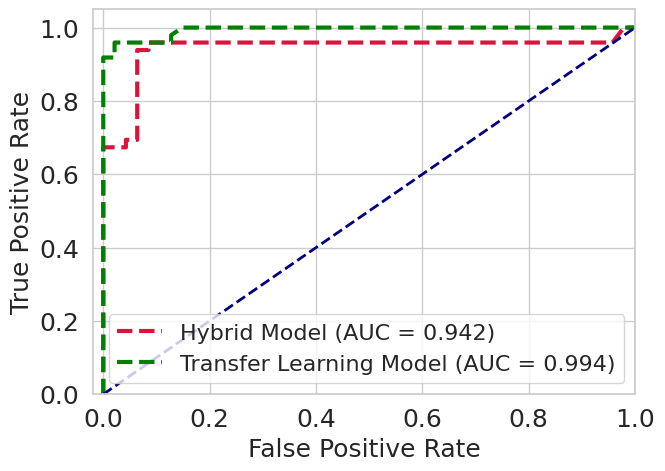

In [118]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for model_1 (assuming sigmoid output)
fpr_1, tpr_1, _ = roc_curve(Y_val, Y_val_pred_prob_1)  # Use predicted probabilities from model_1
roc_auc_1 = roc_auc_score(Y_val, Y_val_pred_prob_1)

# Calculate ROC curve and AUC for model_2 (assuming sigmoid output)
fpr_2, tpr_2, _ = roc_curve(Y_val, Y_val_pred_prob_2)  # Use predicted probabilities from model_2
roc_auc_2 = roc_auc_score(Y_val, Y_val_pred_prob_2)

# Create a single figure
plt.figure(figsize=(7,5))

# Plot ROC curve for model_1
plt.plot(fpr_1, tpr_1, label=f'Hybrid Model (AUC = {roc_auc_1:.3f})', linestyle='--', linewidth=3, color='crimson')

# Plot ROC curve for model_2
plt.plot(fpr_2, tpr_2, label=f'Transfer Learning Model (AUC = {roc_auc_2:.3f})', linestyle='--', linewidth=3, color='green')

# Plot the diagonal line (random classifier reference)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)

# Add title, labels, and legend

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlim([-0.02, 1.0])  # Adjust x-axis limits to start from -0.02
plt.ylim([0.0, 1.05])   # Adjust y-axis limits
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.grid(True)

# Show the combined figure
plt.show()

Processing 111 files in class 'Normal'
Processing 117 files in class 'Pathol'
Processing 47 files in class 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in class 'Pathol'
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


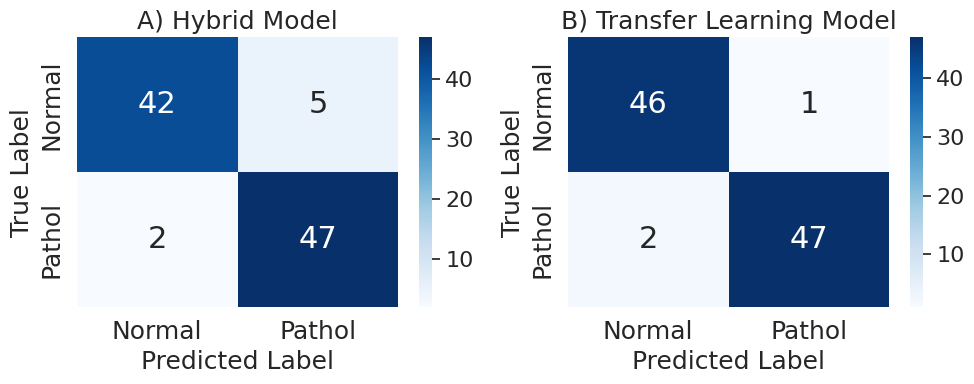

Model 1 Metrics:
Accuracy: 0.93
Precision: 0.90
Recall: 0.96
F1 Score: 0.93

Model 2 Metrics:
Accuracy: 0.97
Precision: 0.98
Recall: 0.96
F1 Score: 0.97

Files misclassified by both models:
File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A1my-62007-nor-f-22-n-4320203565-kaf-0-p - Copy.wav
  True Label: Pathol | Model 1 Prediction: Normal | Model 2 Prediction: Normal
File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A1my-62007-nor-f-22-n-4320203565-kaf-0-p.wav
  True Label: Pathol | Model 1 Prediction: Normal | Model 2 Prediction: Normal


In [119]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa
import glob

# Set base paths for training and validation
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_4'  # Separate test data


classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define the maximum audio length and padding
MAX_AUDIO_LENGTH = 16000  # 1 second of audio at 16 kHz sampling rate

# Function to extract Mel-spectrogram from the audio
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        # Load audio file with librosa (no resampling)
        y, sr = librosa.load(file_path, sr=None)
        # If the audio is shorter than max_len, pad it with zeros
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        # If the audio is longer than max_len, truncate it
        elif len(y) > max_len:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Reshape to match the input of the model (height, width, channels)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Shape (64, time, 1)

        # Replicate the single channel to simulate RGB channels (64, time, 3)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Return a zero vector in case of error
    return mel_spec_db_rgb

def load_data(base_path, classes, labels):
    features = []
    target = []
    file_paths = []  # To store corresponding file paths
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            target.append(labels[class_name])
            file_paths.append(file)  # Save the file path
    return np.array(features), np.array(target), file_paths

# Load training and validation data
X_train, Y_train, train_files = load_data(train_path, classes, labels)
X_val, Y_val, val_files = load_data(test_path, classes, labels)

# Predict on the validation set for model_1
Y_val_pred_prob_1 = model_hyb.predict(X_val)
Y_val_pred_1 = (Y_val_pred_prob_1 > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute confusion matrix for model_1
cm_1 = confusion_matrix(Y_val, Y_val_pred_1, labels=[0, 1])

# Predict on the validation set for model_2
Y_val_pred_prob_2 = model_trans.predict(X_val)
Y_val_pred_2 = (Y_val_pred_prob_2 > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute confusion matrix for model_2
cm_2 = confusion_matrix(Y_val, Y_val_pred_2, labels=[0, 1])

# Plot confusion matrices (same as before)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns_heatmap_1 = sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Normal', 'Pathol'],
                            yticklabels=['Normal', 'Pathol'], cbar=True, ax=axes[0])
axes[0].set_title('A) Hybrid Model', fontsize=18)
axes[0].set_xlabel('Predicted Label', fontsize=18)
axes[0].set_ylabel('True Label', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=18)
for text in axes[0].texts:
    text.set_fontsize(22)
cbar_1 = sns_heatmap_1.collections[0].colorbar
cbar_1.ax.tick_params(labelsize=16)

sns_heatmap_2 = sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Normal', 'Pathol'],
                            yticklabels=['Normal', 'Pathol'], cbar=True, ax=axes[1])
axes[1].set_title('B) Transfer Learning Model', fontsize=18)
axes[1].set_xlabel('Predicted Label', fontsize=18)
axes[1].set_ylabel('True Label', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)
for text in axes[1].texts:
    text.set_fontsize(22)
cbar_2 = sns_heatmap_2.collections[0].colorbar
cbar_2.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()

# Print evaluation metrics for model_1
accuracy_1 = accuracy_score(Y_val, Y_val_pred_1)
precision_1 = precision_score(Y_val, Y_val_pred_1)
recall_1 = recall_score(Y_val, Y_val_pred_1)
f1_1 = f1_score(Y_val, Y_val_pred_1)

print("Model 1 Metrics:")
print(f"Accuracy: {accuracy_1:.2f}")
print(f"Precision: {precision_1:.2f}")
print(f"Recall: {recall_1:.2f}")
print(f"F1 Score: {f1_1:.2f}")

# Print evaluation metrics for model_2
accuracy_2 = accuracy_score(Y_val, Y_val_pred_2)
precision_2 = precision_score(Y_val, Y_val_pred_2)
recall_2 = recall_score(Y_val, Y_val_pred_2)
f1_2 = f1_score(Y_val, Y_val_pred_2)

print("\nModel 2 Metrics:")
print(f"Accuracy: {accuracy_2:.2f}")
print(f"Precision: {precision_2:.2f}")
print(f"Recall: {recall_2:.2f}")
print(f"F1 Score: {f1_2:.2f}")

# Find files misclassified by both models
Y_val_true = np.array(Y_val).flatten()
Y_val_pred_1_flat = Y_val_pred_1
Y_val_pred_2_flat = Y_val_pred_2

misclassified_by_both = [
    i for i in range(len(Y_val_true))
    if Y_val_true[i] != Y_val_pred_1_flat[i] and Y_val_true[i] != Y_val_pred_2_flat[i]
]

# Print file names misclassified by both models
print("\nFiles misclassified by both models:")
for idx in misclassified_by_both:
    true_label = classes[Y_val_true[idx]]
    pred_label_1 = classes[Y_val_pred_1_flat[idx]]
    pred_label_2 = classes[Y_val_pred_2_flat[idx]]
    file_path = val_files[idx]
    print(f"File: {file_path}")
    print(f"  True Label: {true_label} | "
          f"Model 1 Prediction: {pred_label_1} | "
          f"Model 2 Prediction: {pred_label_2}")

In [120]:
# Assuming:
# Y_val_true: true labels (ground truth)
# Y_val_pred_1_flat: predictions from Model 1
# val_files: list of file paths in validation set (in same order as predictions)

# Get indices where true label is 'Normal' (0)
normal_indices = np.where(Y_val_true == 0)[0]

# Get indices where true label is 'Pathol' (1)
pathol_indices = np.where(Y_val_true == 1)[0]

# Find false positives (Normal -> Pathol)
false_positives = [
    i for i in normal_indices
    if Y_val_pred_1_flat[i] == 1
]

# Find false negatives (Pathol -> Normal)
false_negatives = [
    i for i in pathol_indices
    if Y_val_pred_1_flat[i] == 0
]

# Print results
print("\n🔴 False Positives (Normal misclassified as Pathol):")
for idx in false_positives:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Normal | Prediction: Pathol\n")

print("\n🔵 False Negatives (Pathol misclassified as Normal):")
for idx in false_negatives:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Pathol | Prediction: Normal\n")


🔴 False Positives (Normal misclassified as Pathol):
File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-63337-nor-m-29-no-451360-kac-0-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-4333D1FyWy-plp-m-51-n-70083191-rm-3-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-1333D0FyWy-cyt-f-35-n-481117-kac-0-x.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-62007-nor-f-20-no-429202238-kaf-0-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1my-4333D1FyWy-plp-m-51-n-70083191-rm-3-p.wav
  True Label: Normal | Prediction: Pathol


🔵 False Negatives (Pathol misclassified as Normal):
File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A1my-62007-nor-f-22-n-4320203565-kaf-0-p - Copy.wav
  True Label: Pathol | Prediction: Normal

File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A1my-620

In [121]:
# Assuming:
# Y_val_true: true labels (ground truth)
# Y_val_pred_2_flat: predictions from Model 2
# val_files: list of file paths in validation set (in same order as predictions)

# Get indices where true label is 'Normal' (0)
normal_indices = np.where(Y_val_true == 0)[0]

# Get indices where true label is 'Pathol' (1)
pathol_indices = np.where(Y_val_true == 1)[0]

# Find false positives (Normal -> Pathol) for Model 2
false_positives_model2 = [
    i for i in normal_indices
    if Y_val_pred_2_flat[i] == 1
]

# Find false negatives (Pathol -> Normal) for Model 2
false_negatives_model2 = [
    i for i in pathol_indices
    if Y_val_pred_2_flat[i] == 0
]

# Print results for Model 2
print("\n🔴 False Positives (Normal misclassified as Pathol) - Model 2:")
for idx in false_positives_model2:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Normal | Prediction: Pathol\n")

print("\n🔵 False Negatives (Pathol misclassified as Normal) - Model 2:")
for idx in false_negatives_model2:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Pathol | Prediction: Normal\n")


🔴 False Positives (Normal misclassified as Pathol) - Model 2:
File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-1300D7FyWy-cyt-m-10-n-496364-kaf-3-p.wav
  True Label: Normal | Prediction: Pathol


🔵 False Negatives (Pathol misclassified as Normal) - Model 2:
File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A1my-62007-nor-f-22-n-4320203565-kaf-0-p - Copy.wav
  True Label: Pathol | Prediction: Normal

File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A1my-62007-nor-f-22-n-4320203565-kaf-0-p.wav
  True Label: Pathol | Prediction: Normal



Processing 111 files in 'Normal'
Processing 117 files in 'Pathol'
Processing 47 files in 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in 'Pathol'

Training SVM...
SVM - Val Acc: 0.7826, Test F1: 0.8932

Training Random Forest...
Random Forest - Val Acc: 0.7391, Test F1: 0.8842

📊 Performance Comparison:
+----+---------------+----------------+-----------------+----------+-----------+
|    | Model         |   Val Accuracy |   Test Accuracy |   Val F1 |   Test F1 |
+====+===============+================+=================+==========+===========+
|  0 | SVM           |         0.7826 |          0.8854 |   0.8214 |    0.8932 |
+----+---------------+----------------+-----------------+----------+-----------+
|  1 | Random Forest |         0.7391 |          0.8854 |   0.7692 |    0.8842 |
+----+---------------+----------------+-----------------+----------+-----------+


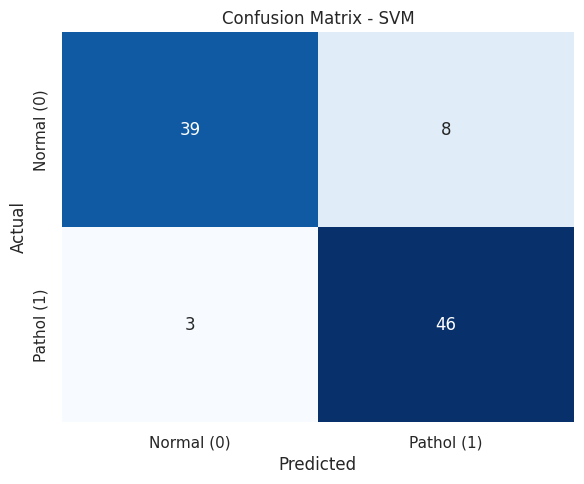

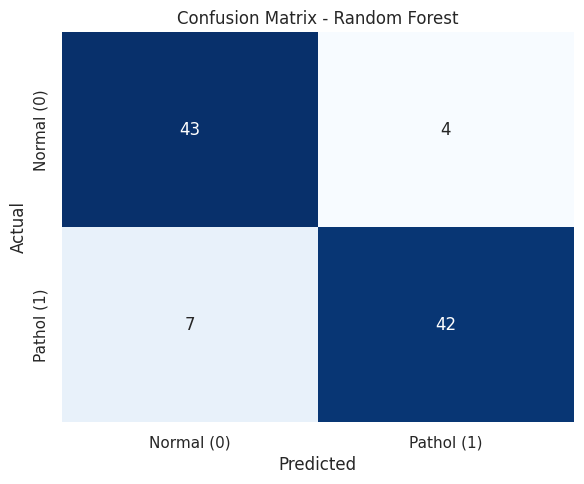

In [122]:
import os
import numpy as np
import librosa
import glob
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Base paths
train_path = '/content/drive/MyDrive/Voice_2/Train'
test_path = '/content/drive/MyDrive/Voice_2/Test_4'

# Audio class labels
classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Fixed audio length and Mel-spectrogram parameters
MAX_AUDIO_LENGTH = 16000
N_MELS = 64
TIME_STEPS = 32

# Function to extract and process Mel-spectrogram
def extract_mel_spectrogram(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        if len(y) < MAX_AUDIO_LENGTH:
            y = np.pad(y, (0, MAX_AUDIO_LENGTH - len(y)), mode='constant')
        else:
            y = y[:MAX_AUDIO_LENGTH]

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        t = mel_spec_db.shape[1]
        if t < TIME_STEPS:
            pad_width = TIME_STEPS - t
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif t > TIME_STEPS:
            mel_spec_db = mel_spec_db[:, :TIME_STEPS]

        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((N_MELS, TIME_STEPS))

# Load data
def load_data(base_path):
    features, targets = [], []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in '{class_name}'")
        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
    return np.array(features), np.array(targets)

# Flatten spectrograms
def flatten_data(X):
    return X.reshape(len(X), -1)

# Load datasets
X_train_val, y_train_val = load_data(train_path)
X_test, y_test = load_data(test_path)

# Split into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Flatten for ML models
X_train_flat = flatten_data(X_train)
X_val_flat = flatten_data(X_val)
X_test_flat = flatten_data(X_test)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Define models
models = {

    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)

}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, Y_train)

    # Predict
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Metrics
    val_acc = accuracy_score(Y_val, y_val_pred)
    val_pre = precision_score(Y_val, y_val_pred)
    val_rec = recall_score(Y_val, y_val_pred)
    val_f1 = f1_score(Y_val, y_val_pred)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_pre = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Val Accuracy": val_acc,
        "Test Accuracy": test_acc,
        "Val F1": val_f1,
        "Test F1": test_f1
    })

    print(f"{name} - Val Acc: {val_acc:.4f}, Test F1: {test_f1:.4f}")

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Print Tabulated Results
print("\n📊 Performance Comparison:")
print(tabulate(df_results, headers="keys", tablefmt="grid", floatfmt=".4f"))

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal (0)', 'Pathol (1)'],
                yticklabels=['Normal (0)', 'Pathol (1)'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


Files misclassified by Model 1 only (but correctly predicted by Model 2):

Files misclassified by Model 2 only (but correctly predicted by Model 1):
File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-4333D1FyWy-plp-m-51-n-70083191-rm-3-p.wav
  True Label: Pathol | Model 1 Prediction: Pathol | Model 2 Prediction: Normal
File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1my-4333D1FyWy-plp-m-51-n-70083191-rm-3-p.wav
  True Label: Pathol | Model 1 Prediction: Pathol | Model 2 Prediction: Normal
File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-62007-nor-f-20-n-430201569-kaf-0-p.wav
  True Label: Pathol | Model 1 Prediction: Pathol | Model 2 Prediction: Normal


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in /content/drive/MyDrive/Voice_2/Train/Normal/*.wav: 111
Files in /content/drive/MyDrive/Voice_2/Train/Pathol/*.wav: 117


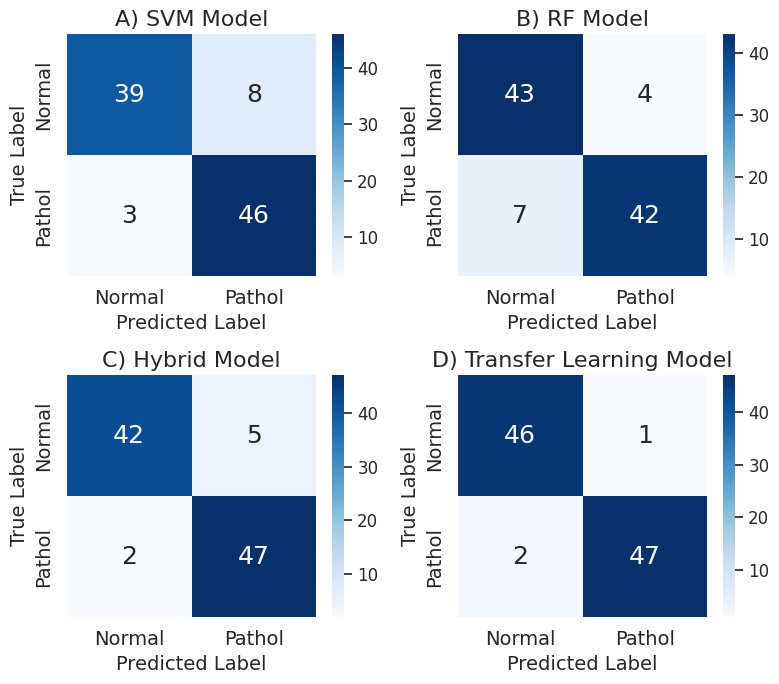

In [123]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Deep Learning Models ---
# Already computed earlier:
# cm_1 = confusion_matrix(Y_val, Y_val_pred_1)
# cm_2 = confusion_matrix(Y_val, Y_val_pred_2)

# --- ML Models ---
ml_cms = []
for name, model in models.items():
    y_test_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    ml_cms.append(cm)

# cm_1 -> Hybrid
# cm_2 -> Transfer Learning
# ml_cms[0] -> SVM
# ml_cms[1] -> Random Forest

# Combine all confusion matrices
cms = [ ml_cms[0], ml_cms[1],cm_1, cm_2]

titles = [

    'A) SVM Model',
    'B) RF Model',
    'C) Hybrid Model',
    'D) Transfer Learning Model',
]

# Create a single figure with 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(8, 7))

for i, ax in enumerate(axes.flat):
    sns.heatmap(cms[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pathol'],
                yticklabels=['Normal', 'Pathol'], cbar=True, ax=ax)

    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Increase annotation font size
    for text in ax.texts:
        text.set_fontsize(18)

    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

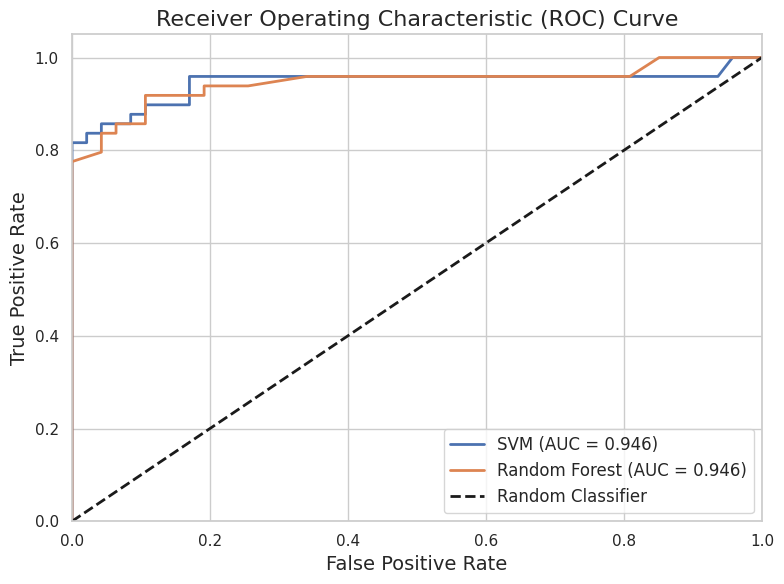

In [124]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Store probabilities and compute ROC curve and AUC for each model
roc_data = []

for name, model in models.items():
    # Get predicted probabilities
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1 (Pathol)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    roc_data.append({
        'name': name,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    })

# Plot all ROC curves
plt.figure(figsize=(8, 6))

for data in roc_data:
    plt.plot(data['fpr'], data['tpr'],
             label='{} (AUC = {:.3f})'.format(data['name'], data['auc']),
             linewidth=2)

# Plot diagonal line (no-skill classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

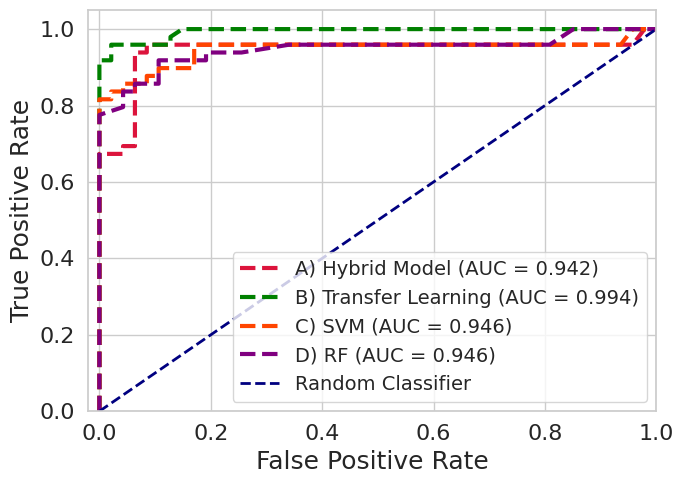

In [133]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Deep Learning Models ---
# Assume fpr_1, tpr_1, roc_auc_1 are already computed from model_1
# Same for fpr_2, tpr_2, roc_auc_2 from model_2

# --- Machine Learning Models ---
roc_data = []
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data.append({
        'name': name,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    })

# --- Plotting Section ---

plt.figure(figsize=(7, 5))

# A) Hybrid Model (DL)
plt.plot(fpr_1, tpr_1,
         label=f'A) Hybrid Model (AUC = {roc_auc_1:.3f})',
         linestyle='--', linewidth=3, color='crimson')

# B) Transfer Learning Model (DL)
plt.plot(fpr_2, tpr_2,
         label=f'B) Transfer Learning (AUC = {roc_auc_2:.3f})',
         linestyle='--', linewidth=3, color='green')

# C) SVM (ML)
plt.plot(roc_data[0]['fpr'], roc_data[0]['tpr'],
         label=f'C) SVM (AUC = {roc_data[0]["auc"]:.3f})',
         linestyle='--', linewidth=3, color='orangered')

# D) Random Forest (ML)
plt.plot(roc_data[1]['fpr'], roc_data[1]['tpr'],
         label=f'D) RF (AUC = {roc_data[1]["auc"]:.3f})',
         linestyle='--', linewidth=3, color='purple')

# Random classifier line
plt.plot([0, 1], [0, 1],
         color='navy', linestyle='--', linewidth=2, label='Random Classifier')

# Formatting
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)

# Show final unified ROC curve
plt.tight_layout()
plt.show()